In [41]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
from openpyxl import load_workbook
from openpyxl.utils.cell import range_boundaries

## Modelo de especificação e utilitários
Aqui ficam o `dataclass` com as opções do gráfico e funções auxiliares de leitura/conversão.

In [85]:
@dataclass(frozen=True)
class ExcelBarChartSpec:
    file_path: Union[str, Path]
    sheet_name: str
    values_range: str
    xlabels_range: str
    ylabel_cell: Optional[str] = None
    title: Optional[str] = None
    highlight_last: bool = True
    output_path: Optional[Union[str, Path]] = None
    show_delta_pct: bool = False
    show_delta_bracket: bool = False
    # Pares (prev, curr) para comparar. Aceita índices negativos (estilo Python).
    # Ex.: ((-2, -1), (-5, -2)) = (penúltimo vs último) e (penúltimo-3 vs penúltimo)
    delta_pairs: Tuple[Tuple[int, int], ...] = ()
    # Para gráficos com poucas barras (ex.: 2), força uma malha maior de categorias
    # para as barras ficarem com largura visual similar ao gráfico principal.
    fixed_slot_count: Optional[int] = None


def _read_range_row(ws, cell_range: str) -> List[object]:
    min_col, min_row, max_col, max_row = range_boundaries(cell_range)
    out: List[object] = []
    for r in range(min_row, max_row + 1):
        for c in range(min_col, max_col + 1):
            out.append(ws.cell(row=r, column=c).value)
    return out


def _to_float_list(values: List[object]) -> List[float]:
    out: List[float] = []
    for v in values:
        if v is None or (isinstance(v, str) and v.strip() == ""):
            out.append(0.0)
            continue
        try:
            out.append(float(v))
        except (TypeError, ValueError) as exc:
            raise ValueError(f"Valor não numérico no range: {v!r}") from exc
    return out


def _pchip_interpolate(x: np.ndarray, y: np.ndarray, x_new: np.ndarray) -> np.ndarray:
    """Monotone cubic interpolation (PCHIP) in NumPy only.

    Produz uma curva suave sem 'overshoot' entre pontos (bom para séries financeiras).
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    x_new = np.asarray(x_new, dtype=float)
    n = x.size
    if n < 2:
        return np.full_like(x_new, y[0] if n else np.nan, dtype=float)
    if np.any(np.diff(x) <= 0):
        raise ValueError("x deve ser estritamente crescente")

    h = np.diff(x)
    delta = np.diff(y) / h
    d = np.zeros(n, dtype=float)

    if n == 2:
        d[0] = delta[0]
        d[1] = delta[0]
    else:
        # Tangentes internas
        for i in range(1, n - 1):
            if delta[i - 1] == 0.0 or delta[i] == 0.0 or np.sign(delta[i - 1]) != np.sign(delta[i]):
                d[i] = 0.0
            else:
                w1 = 2 * h[i] + h[i - 1]
                w2 = h[i] + 2 * h[i - 1]
                d[i] = (w1 + w2) / (w1 / delta[i - 1] + w2 / delta[i])

        # Endpoints (Fritsch–Carlson)
        d0 = ((2 * h[0] + h[1]) * delta[0] - h[0] * delta[1]) / (h[0] + h[1])
        if np.sign(d0) != np.sign(delta[0]):
            d0 = 0.0
        elif (np.sign(delta[0]) != np.sign(delta[1])) and (abs(d0) > abs(3 * delta[0])):
            d0 = 3 * delta[0]
        d[0] = d0

        dn = ((2 * h[-1] + h[-2]) * delta[-1] - h[-1] * delta[-2]) / (h[-1] + h[-2])
        if np.sign(dn) != np.sign(delta[-1]):
            dn = 0.0
        elif (np.sign(delta[-1]) != np.sign(delta[-2])) and (abs(dn) > abs(3 * delta[-1])):
            dn = 3 * delta[-1]
        d[-1] = dn

    # Avaliação por trecho (vectorizado)
    idx = np.searchsorted(x, x_new, side="right") - 1
    idx = np.clip(idx, 0, n - 2)
    xk = x[idx]
    xk1 = x[idx + 1]
    hk = xk1 - xk
    t = (x_new - xk) / hk

    yk = y[idx]
    yk1 = y[idx + 1]
    dk = d[idx]
    dk1 = d[idx + 1]

    t2 = t * t
    t3 = t2 * t
    h00 = 2 * t3 - 3 * t2 + 1
    h10 = t3 - 2 * t2 + t
    h01 = -2 * t3 + 3 * t2
    h11 = t3 - t2

    return h00 * yk + h10 * hk * dk + h01 * yk1 + h11 * hk * dk1

## Função: gráfico de barras
Lê valores e rótulos do Excel e gera um gráfico de barras, com destaque opcional na última barra.

In [104]:
def plot_bar_from_excel(spec: ExcelBarChartSpec) -> Tuple[plt.Figure, plt.Axes]:
    file_path = Path(spec.file_path)
    if not file_path.exists():
        raise FileNotFoundError(f"Arquivo não encontrado: {file_path}")

    wb = load_workbook(filename=file_path, data_only=True)
    if spec.sheet_name not in wb.sheetnames:
        raise ValueError(
            f"Aba não encontrada: {spec.sheet_name!r}. Disponíveis: {wb.sheetnames}"
        )

    ws = wb[spec.sheet_name]

    values = _to_float_list(_read_range_row(ws, spec.values_range))
    xlabels = ["" if v is None else str(v) for v in _read_range_row(ws, spec.xlabels_range)]

    if len(values) != len(xlabels):
        raise ValueError(f"Tamanhos diferentes: valores={len(values)} xlabels={len(xlabels)}")

    fig, ax = plt.subplots(figsize=(10, 4.8))
    # Fundo transparente
    fig.patch.set_alpha(0)
    ax.set_facecolor("none")

    n = len(values)

    colors = ["#8d98a6"] * n
    if spec.highlight_last and colors:
        colors[-1] = "#123a7a"

    # Mantém a "espessura" visual do gráfico principal sem criar áreas vazias no PNG.
    # Para o 9M (2 barras), também reduz o espaçamento e aumenta fontes (tudo fica legível).
    base_width = 0.8
    slot_count = int(spec.fixed_slot_count) if spec.fixed_slot_count else n
    slot_count = max(slot_count, n)
    ratio = n / slot_count if slot_count else 1.0
    width = base_width if slot_count == n else base_width * float(np.sqrt(ratio))

    is_9m_two_bars = bool(spec.fixed_slot_count) and n == 2 and slot_count > n

    # Fontes
    font_base = 9
    if is_9m_two_bars:
        font_base = 12
    font_value = font_base
    font_xtick = font_base
    font_delta = font_base

    step = 1.0
    x_pad = 0.5
    if is_9m_two_bars:
        step = 0.48
        x_pad = 0.35
    x_pos = np.arange(n, dtype=float) * step

    bars = ax.bar(x_pos, values, width=width, color=colors, edgecolor="none")
    ax.set_xlim(x_pos.min() - x_pad, x_pos.max() + x_pad)

    # Rótulo do valor em cada barra (último em negrito)
    last_idx = n - 1
    for i, (rect, val) in enumerate(zip(bars, values)):
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            rect.get_height(),
            f"{val:,.0f}".replace(",", "."),
            ha="center",
            va="bottom",
            fontsize=font_value,
            fontweight="bold" if i == last_idx else "normal",
            color="#2f2f2f",
        )

    # Variação % entre períodos (pares customizáveis)
    delta_label_top: Optional[float] = None
    if spec.show_delta_pct and n >= 2:
        vals = np.asarray(values, dtype=float)
        abs_max = float(np.nanmax(np.abs(vals))) if np.isfinite(np.nanmax(np.abs(vals))) else 0.0
        offset_y = max(abs_max * 0.06, 0.5)
        bracket_h = max(abs_max * 0.03, 0.5)

        pairs = list(spec.delta_pairs) if spec.delta_pairs else [(i - 1, i) for i in range(1, n)]

        def _norm_index(idx: int) -> int:
            return idx + n if idx < 0 else idx

        norm_pairs: List[Tuple[int, int]] = []
        for prev_i, curr_i in pairs:
            pi = _norm_index(int(prev_i))
            ci = _norm_index(int(curr_i))
            if pi < 0 or pi >= n or ci < 0 or ci >= n or pi == ci:
                continue
            norm_pairs.append((pi, ci))

        norm_pairs_sorted = sorted(norm_pairs, key=lambda p: (abs(p[1] - p[0]), p[0], p[1]))

        for level, (pi, ci) in enumerate(norm_pairs_sorted):
            prev = vals[pi]
            curr = vals[ci]
            if not np.isfinite(prev) or not np.isfinite(curr) or prev == 0:
                continue
            pct = (curr / prev - 1.0) * 100.0
            label = f"{pct:+.1f}%".replace(".", ",")

            x1 = bars[pi].get_x() + bars[pi].get_width() / 2
            x2 = bars[ci].get_x() + bars[ci].get_width() / 2

            top = max(prev, curr)
            base = top + offset_y if top >= 0 else top - offset_y
            y_anchor = base + level * (bracket_h + offset_y * 0.9)

            if spec.show_delta_bracket:
                ax.plot(
                    [x1, x1, x2, x2],
                    [y_anchor, y_anchor + bracket_h, y_anchor + bracket_h, y_anchor],
                    color="#2f2f2f",
                    linewidth=1.2,
                    solid_capstyle="round",
                    zorder=4,
                )
                text_y = y_anchor + bracket_h + offset_y * 0.25
            else:
                text_y = y_anchor

            ax.text(
                (x1 + x2) / 2.0,
                text_y,
                label,
                ha="center",
                va="bottom",
                fontsize=font_delta,
                color="#2f2f2f",
                zorder=5,
            )
            delta_label_top = text_y if delta_label_top is None else max(delta_label_top, text_y)

        if delta_label_top is not None:
            cur_ymin, cur_ymax = ax.get_ylim()
            ax.set_ylim(cur_ymin, max(cur_ymax, delta_label_top + offset_y))

    # Só eixo X + barras (remove Y e moldura)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(xlabels, rotation=0, fontsize=font_xtick)
    ax.set_ylabel("")
    ax.set_yticks([])
    for s in ("left", "right", "top"):
        ax.spines[s].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.tick_params(axis="y", left=False, labelleft=False)
    ax.yaxis.grid(False)
    ax.margins(x=0.02, y=0.10)

    fig.tight_layout(pad=0.2)

    if spec.output_path:
        out = Path(spec.output_path)
        out.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out, dpi=220, transparent=True, bbox_inches="tight", pad_inches=0.05)

    return fig, ax

## Função: gráfico de linha
Versão para série temporal (ou sequência) com rótulos e anotação de valores.

In [101]:
def plot_line_from_excel(
    file_path: Union[str, Path],
    sheet_name: str,
    values_range: str,
    xlabels_range: str,
    title: Optional[str] = None,
    output_path: Optional[Union[str, Path]] = None,
    fmt_as_percent: bool = True,
    smooth: bool = True,
    smooth_points: int = 250,
    show_markers: bool = True,
    y_baseline: Optional[float] = None,
    y_limits: Optional[Tuple[float, float]] = None,
    y_expand: float = 0.0,
    marker_color: str = "#123a7a",
    label_offset_pts: float = 10.0,
    line_width: float = 2.2,
    label_fontsize: float = 9.0,
    marker_size: float = 26.0,
 ) -> Tuple[plt.Figure, plt.Axes]:
    file_path = Path(file_path)
    if not file_path.exists():
        raise FileNotFoundError(f"Arquivo não encontrado: {file_path}")

    wb = load_workbook(filename=file_path, data_only=True)
    if sheet_name not in wb.sheetnames:
        raise ValueError(f"Aba não encontrada: {sheet_name!r}. Disponíveis: {wb.sheetnames}")

    ws = wb[sheet_name]

    values = _to_float_list(_read_range_row(ws, values_range))
    xlabels = ["" if v is None else str(v) for v in _read_range_row(ws, xlabels_range)]
    if len(values) != len(xlabels):
        raise ValueError(f"Tamanhos diferentes: valores={len(values)} xlabels={len(xlabels)}")

    x = np.arange(len(values), dtype=float)
    y = np.asarray(values, dtype=float)

    fig, ax = plt.subplots(figsize=(10, 4.2))
    # Fundo transparente
    fig.patch.set_alpha(0)
    ax.set_facecolor("none")

    # Linha suavizada (mantém os pontos reais e só suaviza o traço)
    if smooth and len(values) >= 3:
        xs = np.linspace(x.min(), x.max(), num=max(int(smooth_points), len(values) * 50))
        ys = _pchip_interpolate(x, y, xs)
        ax.plot(
            xs,
            ys,
            linewidth=float(line_width),
            color="#2f2f2f",
            solid_joinstyle="round",
            solid_capstyle="round",
            zorder=2,
        )
    else:
        ax.plot(
            x,
            y,
            linewidth=float(line_width),
            color="#2f2f2f",
            solid_joinstyle="round",
            solid_capstyle="round",
            zorder=2,
        )

    if show_markers:
        ax.scatter(x, y, s=float(marker_size), color=marker_color, zorder=3)

    # Labels (último em negrito)
    last_idx = len(values) - 1
    for i, (xi, yi) in enumerate(zip(x, y)):
        label = f"{yi:.1f}%".replace(".", ",") if fmt_as_percent else str(yi)
        ax.annotate(
            label,
            (xi, yi),
            textcoords="offset points",
            xytext=(0, label_offset_pts),
            ha="center",
            va="bottom",
            fontsize=float(label_fontsize),
            color="#2f2f2f",
            fontweight="bold" if i == last_idx else "normal",
        )

    # Ajuste do eixo Y (opcional)
    if y_limits is not None:
        ymin, ymax = float(y_limits[0]), float(y_limits[1])
        ax.set_ylim(ymin, ymax)
    else:
        ymin = float(np.nanmin(y))
        ymax = float(np.nanmax(y))
        if y_baseline is not None:
            ymin = min(ymin, float(y_baseline))
            ymax = max(ymax, float(y_baseline))
        yr = ymax - ymin
        if not np.isfinite(yr) or yr <= 0:
            yr = 1.0
        if y_expand and y_expand > 0:
            ymin -= yr * float(y_expand)
            ymax += yr * float(y_expand)
        ax.set_ylim(ymin, ymax)

    # Só a linha + pontos + valores (sem eixos/títulos/grade). Eixo X não aparece.
    for s in ("left", "right", "top", "bottom"):
        ax.spines[s].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.grid(False)
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.margins(x=0.03, y=0.08)

    fig.tight_layout(pad=0.2)

    if output_path:
        out = Path(output_path)
        out.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out, dpi=220, transparent=True, bbox_inches="tight", pad_inches=0.08)

    return fig, ax

## Execução (equivalente ao `if __name__ == "__main__"`)
Ajuste `file_path` para o seu Excel e rode as células abaixo.

In [45]:
# Ajuste aqui o nome/caminho do seu arquivo
EXCEL_FILE = "/home/renato/ppt-doc/testing.xlsx"

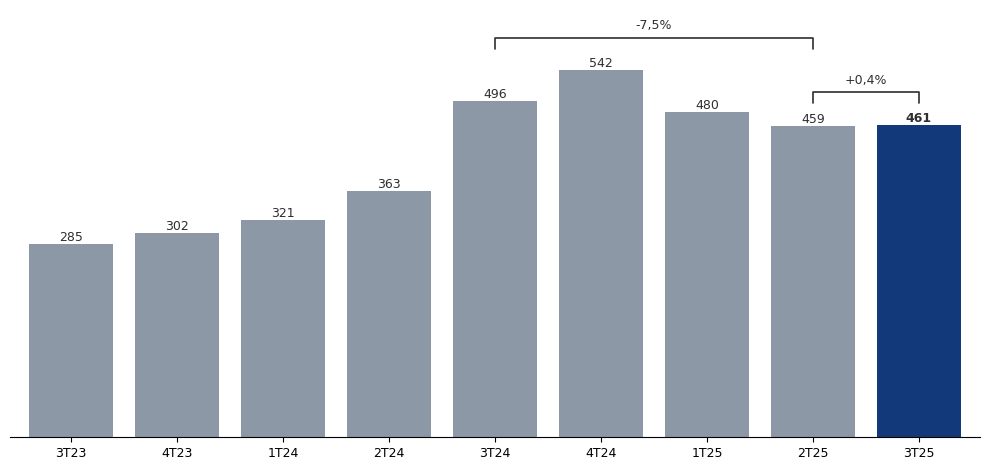

In [81]:
# 1) Gráfico barras: Trimestres (D:H)
plot_bar_from_excel(
    ExcelBarChartSpec(
        file_path=EXCEL_FILE,
        sheet_name="DRE Saida",
        values_range="C18:K18",
        xlabels_range="C3:K3",
        ylabel_cell="B18",
        title="Lucro Líquido - Trimestres",
        highlight_last=True,
        show_delta_pct=True,
        show_delta_bracket=True,
        # Lógica pedida: último vs penúltimo; penúltimo vs (penúltimo - 3)
        # (-2 vs -1) = 2T25 -> 3T25; (-5 vs -2) = 3T24 -> 2T25
        delta_pairs=((-2, -1), (-5, -2)),
        output_path="01_lucro_trimestres.png",
    )
)
plt.show()

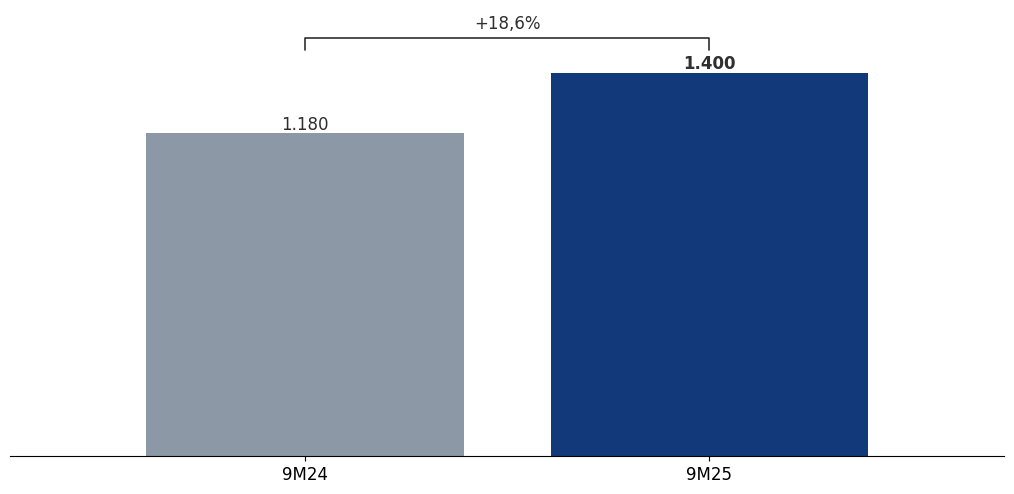

In [105]:
# 2) Gráfico barras: 9M (L:M)
plot_bar_from_excel(
    ExcelBarChartSpec(
        file_path=EXCEL_FILE,
        sheet_name="DRE Saida",
        values_range="L18:M18",
        xlabels_range="L3:M3",
        ylabel_cell="C18",
        title="Lucro Líquido - 9M",
        highlight_last=True,
        show_delta_pct=True,
        show_delta_bracket=True,
        # Força a mesma malha de "slots" do gráfico principal (C:K = 9 valores),
        # para as barras não ficarem visualmente largas demais com apenas 2 colunas.
        fixed_slot_count=9,
        output_path="02_lucro_9m.png",
    )
)
plt.show()

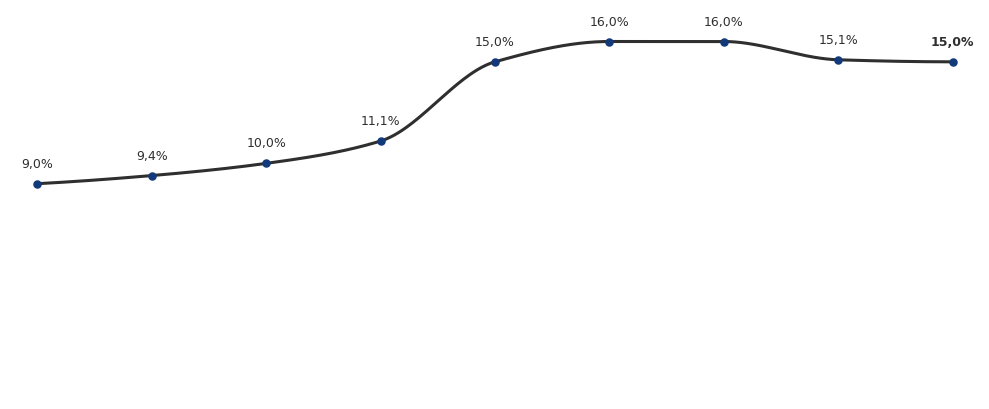

In [83]:
# 3) (Opcional) Linha ROE: Trimestres (ajuste o range do ROE no seu Excel)
plot_line_from_excel(
    file_path=EXCEL_FILE,
    sheet_name="DRE Saida",
    values_range="C20:K20",
    xlabels_range="C3:K3",
    title="ROE - Trimestres",
    output_path="03_roe_trimestres.png",
    fmt_as_percent=True,
    y_baseline=0.0,
    y_expand=0.10,
 )
plt.show()

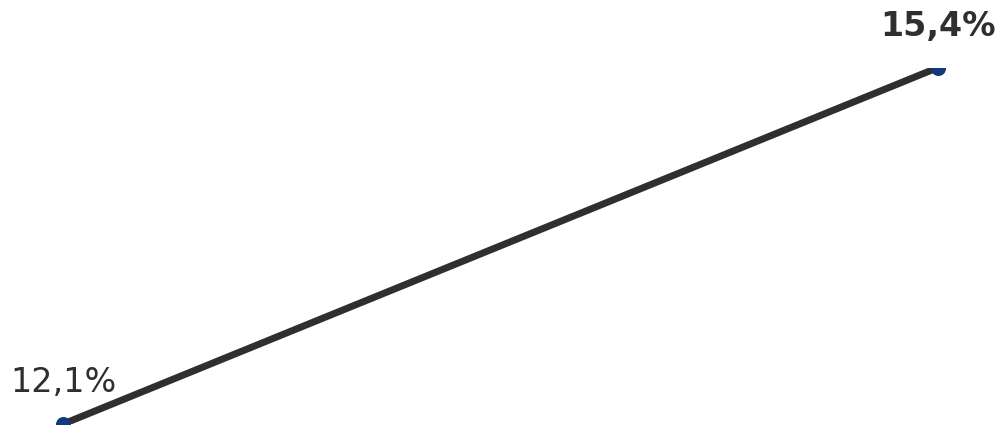

In [103]:
# 4) (Opcional) Linha ROE: 9M (ajuste o range)
plot_line_from_excel(
    file_path=EXCEL_FILE,
    sheet_name="DRE Saida",
    values_range="L20:M20",
    xlabels_range="L3:M3",
    title="ROE - 9M",
    output_path="04_roe_9m.png",
    fmt_as_percent=True,
    # Ajuste pedido: fonte maior, linha mais grossa e ponto maior no 9M (2 pontos)
    line_width=5.0,
    label_fontsize=24.0,
    marker_size=96.0,
    label_offset_pts=18.0,
 )
plt.show()